# Creating records 
## Pipeline 1.0 (no parquet)
##### ASTROMER dev team

*July 07 2023*

In [74]:
cd /home

/home


In [75]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

from src.data.old_record import DataPipeline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [76]:
METAPATH    = './data/raw_data/alcock/metadata.csv'
OBSPATH     = './data/raw_data/alcock/LCs/'
config_path = './data/raw_data/alcock/config_old.toml'

In [77]:
metadata = pd.read_csv(METAPATH)

In [78]:
metadata['Class'] = pd.Categorical(metadata['Class'])
metadata['Label'] = metadata['Class'].cat.codes
metadata['Path'] = metadata['Path'].apply(lambda x: os.path.join(OBSPATH, x)) 

In [79]:
metadata.sample()

,ID,Class,Path,Band,Label
6992,2.5267.449,RRab,./data/raw_data/alcock/LCs/2.5267.449.dat,1.0,4


### Using DataPipeline class

In [25]:
# Create an instance of DataPipeline
pipeline = DataPipeline(metadata=metadata,
                        config_path=config_path)

[INFO] 21444 samples loaded


In [26]:
pipeline.sequential_features_dtype

['float', 'float', 'float']

To create training, validation, and testing splits we need to use the `train_val_test` method 
```
train_val_test(val_frac=0.2,
               test_frac=0.2,
               test_meta=None,
               val_meta=None,
               shuffle=True,
               id_column_name=None,
               k_fold=1)
``` 
where `val_frac` and `test_frac` are percentages containing the fraction of the metadata to be used as validation and testing subset respectively. 

Additionally, you can use `val_meta` and `test_meta` to use a preselected subset. **Notice that if you employ your own test/val subset, you should match one of the identifier columns of the main DataFrame** (by default it will assume the first column of the dataset is the identifier). 

Both `test_meta` and `val_meta` must be list of `DataFrames`

For cross-validation purposes, we can also sample different folds from the same dataset by using the `train_val_test(..., k_fold=1)` parameter.

If $k>1$ and **you want to use a predefined test/val selection**, you should pass a list of `DataFrame`s associated with each `test_meta`/`val_meta` fold as appropriate.

Don't worry about removing duplicated indices, the `train_val_test` method will do it for you.

In [27]:
test_metadata = metadata.sample(n=100)

In [28]:
k_folds = 3
pipeline.train_val_test(val_frac=0.2, 
                        test_meta=[test_metadata]*k_folds, 
                        k_fold=k_folds)

[INFO] Using ID col as sample identifier
[INFO] Shuffling
[INFO] Shuffling
[INFO] Shuffling


In [29]:
a = pipeline.metadata['subset_0']
for k in range(k_folds):
    if k == 0: continue
    b = pipeline.metadata[f'subset_{k}']
    c = np.array_equal(a[a != 'test'].values, b[b!= 'test'].values)
    a = b
    print('Do {}-folds partitions have the same elements: '.format(k_folds), c)

Do 3-folds partitions have the same elements:  False
Do 3-folds partitions have the same elements:  False


Now our metadata will contain an extra-column `subset` for the corresponding subset

In [41]:
pipeline.metadata.sample(3)

,ID,Class,Path,Band,Label,subset_0,subset_1,subset_2
5168,17.3069.219,UNK,./data/raw_data/alcock/LCs/17.3069.219.dat,1.0,6,validation,train,train
2359,12.10196.725,RRc,./data/raw_data/alcock/LCs/12.10196.725.dat,1.0,5,validation,train,train
16809,79.4775.1810,UNK,./data/raw_data/alcock/LCs/79.4775.1810.dat,1.0,6,train,train,train


In [47]:
for k in range(k_folds):
    train_subset = pipeline.metadata[pipeline.metadata[f'subset_{k}'] == 'train']
    val_subset   = pipeline.metadata[pipeline.metadata[f'subset_{k}'] == 'validation']
    test_subset  = pipeline.metadata[pipeline.metadata[f'subset_{k}'] == 'test']

    print(train_subset.shape, val_subset.shape, test_subset.shape)

    print('test in train?: ', test_subset['ID'].isin(train_subset['ID']).all(),'\n',
          'val in train?: ', val_subset['ID'].isin(train_subset['ID']).all(),'\n',
          'val in test?: ', val_subset['ID'].isin(test_subset['ID']).all())

(17075, 8) (4269, 8) (100, 8)
test in train?:  False 
 val in train?:  False 
 val in test?:  False
(17075, 8) (4269, 8) (100, 8)
test in train?:  False 
 val in train?:  False 
 val in test?:  False
(17075, 8) (4269, 8) (100, 8)
test in train?:  False 
 val in train?:  False 
 val in test?:  False


Notice if you want to redo, you must initialize the object `DataPipeline` again

Now it is **time to the pipeline**

In [48]:
pipeline.context_features, pipeline.context_features_dtype

(['ID', 'Label', 'Class', 'Band'], ['string', 'integer', 'string', 'integer'])

In [49]:
%%time
var = pipeline.run(n_jobs=8)

Writting test fold 2:   0%|                                           | 0/3 [01:37<?, ?it/s]

CPU times: user 1min 22s, sys: 5.89 s, total: 1min 28s
Wall time: 1min 37s


### Customize what happens within the preprocess function

You must keep the same parameters of the method i.e., `row, context_features, sequential_features`. 

Also the **output** should be tuple containing the lightcurve (`pd.DataFrame`) and the context values row(`pd.Series`)


To modify the `process_sample` method we need to create a new class (`MyPipeline`) that inherits from `DataPipeline` 

In [86]:
class MyPipeline(DataPipeline):
    @staticmethod
    def process_sample(row, context_features, sequential_features):
        observations = pd.read_csv(row['Path'])
        observations.columns = ['mjd', 'mag', 'errmag']
        observations = observations.dropna()
        observations.sort_values('mjd', ascending=False)
        observations[observations['errmag'] < -2]
        
        return observations, row

Next steps are the same as using the original `DataPipeline` class

In [87]:
custom_pipeline = MyPipeline(metadata=metadata,
                             config_path=config_path)

[INFO] 21444 samples loaded


In [88]:
test_metadata = metadata.sample(n=100)
k_folds = 3
custom_pipeline.train_val_test(val_frac=0.2, 
                               test_meta=[test_metadata]*k_folds, 
                               k_fold=k_folds)

[INFO] Using ID col as sample identifier
[INFO] Shuffling
[INFO] Shuffling
[INFO] Shuffling


In [97]:
%%time
var = custom_pipeline.run(n_jobs=8)


Writting test fold 2:   0%|                                           | 0/3 [01:41<?, ?it/s]

CPU times: user 1min 28s, sys: 7.36 s, total: 1min 35s
Wall time: 1min 41s


# Reading

In [98]:
import tensorflow as tf
from src.data.record import deserialize
import glob

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [99]:
root = './data/records/alcock_2/fold_0/train/'
record_files = glob.glob(os.path.join(root, '*.record'))

raw_dataset = tf.data.TFRecordDataset(record_files)
raw_dataset = raw_dataset.map(lambda x: deserialize(x, root))

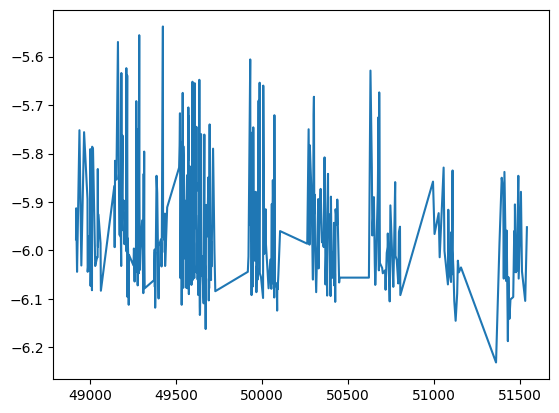

In [100]:
for x in raw_dataset.take(1):
    plt.plot(x['input'][0, ..., 0], x['input'][0, ..., 1])